In [15]:
%matplotlib widget
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from skimage.io import imread
from skimage.transform import resize
from rembg import remove
from PIL import Image, ImageFilter
import os
import cv2
import torch
import pandas as pd
from torch.utils.data import Dataset, ConcatDataset, random_split
import Script.Diffusion_tools as diffusion_utils
import Script.Autonomous_tools as autonomous_tools
import Script.auto_models as  auto_models
from PIL import Image, ImageFilter
import re
scenarios_dir = "/media/kai/K/RMT_LLM/0_Data/Diffusion/Reference/A2D2"
Use_time_series = True
scenario_num=0
sorted_scenarios = sorted(os.listdir(scenarios_dir), key=lambda x: int(re.search(r'scenario_(\d+)', x).group(1)))
scenarios_file = scenarios_dir+"/"+sorted_scenarios[scenario_num]

In [13]:
scenario_num=9
import json
scenarios_file = scenarios_dir+"/"+sorted_scenarios[scenario_num]
save_dir = scenarios_dir+"/"+sorted_scenarios[scenario_num]+"/results/fourth"
save_dir_5 = scenarios_dir+"/"+sorted_scenarios[scenario_num]+"/results/fifth"
diffusion_utils.Check_file(save_dir)
diffusion_utils.Check_file(save_dir_5)

temp_fig_dir = scenarios_file + "/figs"
dataset = "a2d2"
if dataset == 'a2d2':
    image_paths = diffusion_utils.get_all_image_paths_A2D2(temp_fig_dir)
    image_paths = image_paths[::3]
else:
    image_paths = diffusion_utils.get_all_image_paths_Udacity(temp_fig_dir)
    image_paths = image_paths[::2]

image_paths = diffusion_utils.get_all_image_paths_1(scenarios_dir+"/"+sorted_scenarios[scenario_num]+"/results/first/frame_rm_w_mask_dir", "*.png")
kernel_1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (35, 35))
road_dirs = scenarios_file + "/results/second/mask_0"
road_dirs = diffusion_utils.get_all_image_paths_1(road_dirs, "*.jpg")
###################################################### 加载目标
with open(scenarios_dir+"/"+sorted_scenarios[scenario_num]+'/results/info.json', 'r') as file:
    data = json.load(file)
##############################################################


In [58]:
object_dirs = "/media/kai/K/RMT_LLM/0_Data/Diffusion/Reference/Fine-tuning/Sign"
object_dirs = diffusion_utils.get_all_image_paths_1(object_dirs, "*.png")

In [19]:
object_0_ = Image.open("temp.png")
object_mask_ = remove(object_0_,threshold=1, only_mask=True)
object_mask_ = object_mask_.resize(object_0_.size, Image.LANCZOS)

In [102]:
mp = np.array(object_mask)
mp.shape

(1024, 1024)

In [101]:
original_size = object_0.size
object_mask = object_mask.resize(original_size, Image.LANCZOS)

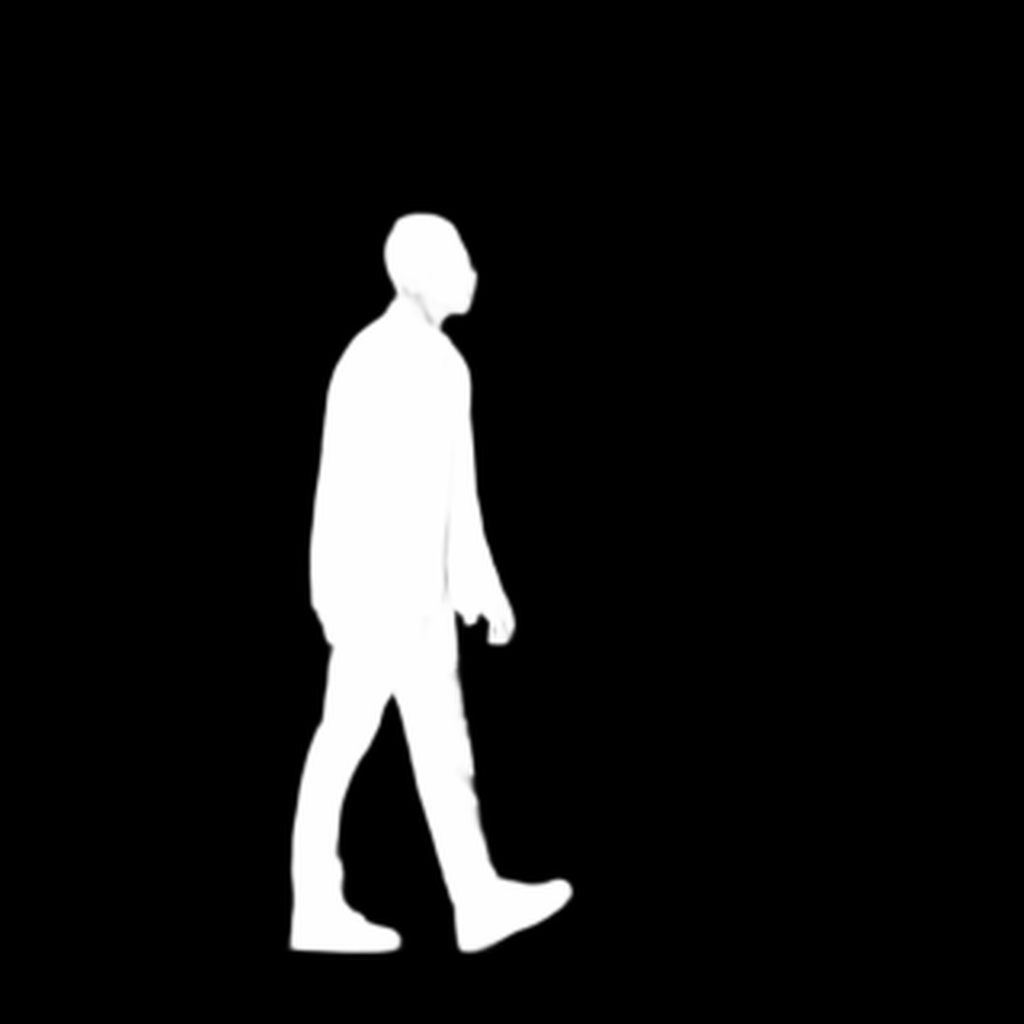

In [22]:
object_mask_

In [21]:


args = [1,0,0]

temp_height = 0
temp_width = 0

#object_0_ = Image.open("temp.png")
#object_mask_ = remove(object_0,threshold=1, only_mask=True)
#object_mask_ = object_mask.resize(object_0.size, Image.LANCZOS)

#object_mask = remove(object_0,threshold=1, only_mask=True)
for cont in range(len(image_paths)):
    file_name = os.path.basename(road_dirs[cont])
    file_name_1 = save_dir + '/' + file_name
    #object_0 = Image.open(object_dirs[0])
    object_0 = object_0_.copy()
    object_mask = object_mask_.copy()
    
    temp_image = Image.open(image_paths[cont])
    
    boxx = data[cont]['white_bbox']
    width, height = boxx[2]-boxx[0], boxx[3]-boxx[1]
    
    if temp_height<height:
        temp_height = height 
    else:
        height = temp_height
    if temp_width<width:
        temp_width = width 
    else:
        width = temp_width
    
    max_size = (height*args[0], width*args[0])#(width*args[0],height*args[0])
    #print(max_size)
    object_0.thumbnail(max_size, Image.LANCZOS)
    #object_mask.thumbnail(max_size, Image.LANCZOS)
    object_mask = object_mask.resize(object_0.size, Image.LANCZOS)
    if args[2]==0:
        x = boxx[0]+args[1]#-width//2
        y = boxx[1]
    elif args[2]==1:
        if cont==0:
            x = boxx[0]+args[1]
            y = boxx[1]
    temp_image.paste(object_0, (x,y),mask = object_mask)
    temp_image.save(file_name_1)

    file_name_5 = save_dir_5 + '/' + file_name

    # 创建一个与temp_image大小相同的黑色遮罩
    mask = Image.new('L', temp_image.size, 0)
    
    # 将object_mask粘贴到遮罩上的相应位置
    mask.paste(object_mask, (x, y))
    mask.save(file_name_5)
    

In [80]:
max_size

(1191, 720)

In [111]:
Source_images = diffusion_utils.get_all_image_paths_1(save_dir, "*.jpg")
Source_images = Source_images[:36]
save_video = 'output.mp4'#save_dir+'/output.mp4'
diffusion_utils.images_to_video_1(Source_images,save_video,10)
Source_images = Source_images[::3]
save_video ='video.mp4' #save_dir+'/output.mp4'
diffusion_utils.images_to_video_1(Source_images,save_video,3)

视频已创建：output.mp4
视频已创建：video.mp4


In [113]:
objects_dirs = scenarios_dir+"/"+sorted_scenarios[scenario_num_1] + "/results/third"
objects_dirs = diffusion_utils.get_all_image_paths_1(objects_dirs, "*.jpg")

In [114]:
image = load_image(objects_dirs[-1])
depth_image = get_depth_map(image)

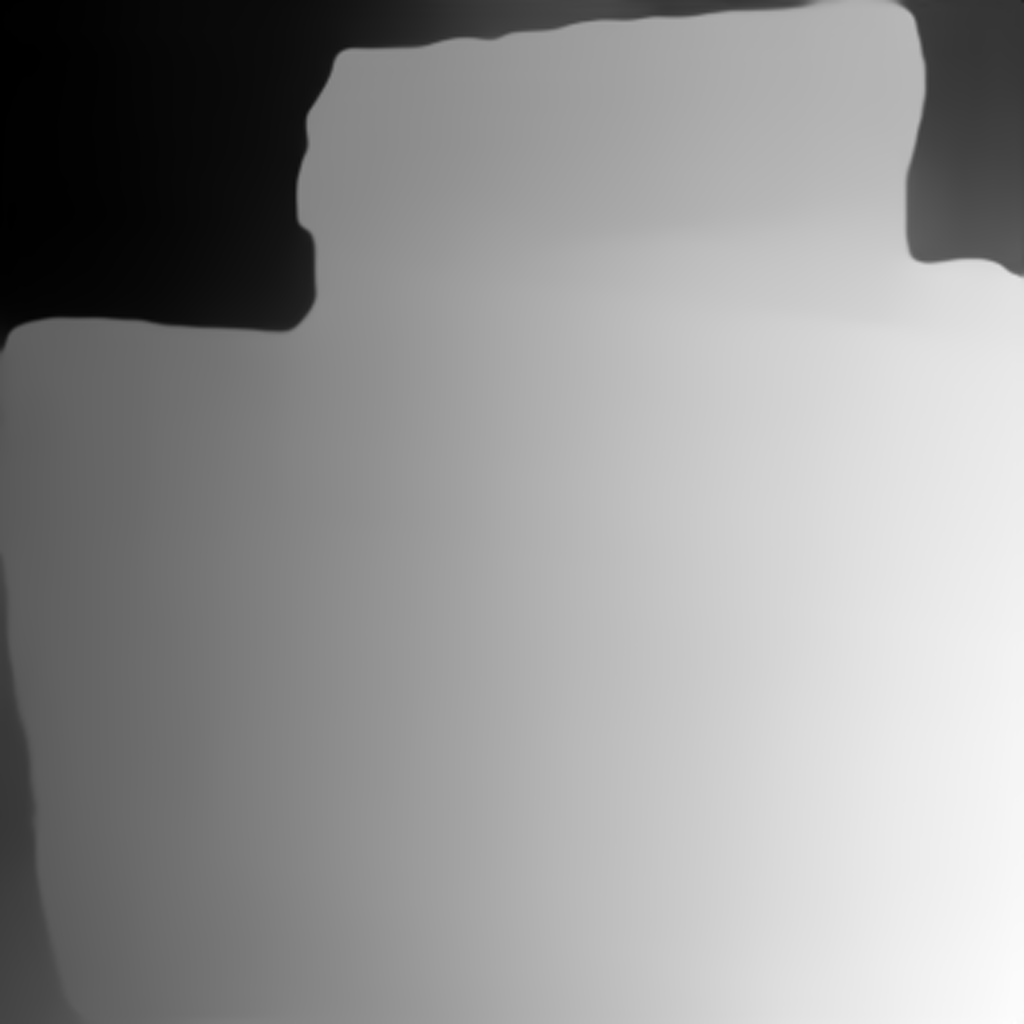

In [115]:
depth_image

In [65]:
import torch
import numpy as np
from PIL import Image
from transformers import DPTFeatureExtractor, DPTForDepthEstimation
from diffusers import ControlNetModel, StableDiffusionXLControlNetPipeline
from diffusers.utils import load_image, make_image_grid
import sys
sys.path.insert(0, '/media/kai/K/RMT_LLM/2_Diffusion_tools/stable diffusion/TCD')
from scheduling_tcd import TCDScheduler 

device = "cuda"
depth_estimator = DPTForDepthEstimation.from_pretrained("Intel/dpt-hybrid-midas").to(device)
feature_extractor = DPTFeatureExtractor.from_pretrained("Intel/dpt-hybrid-midas")

def get_depth_map(image):
    image = feature_extractor(images=image, return_tensors="pt").pixel_values.to(device)
    with torch.no_grad(), torch.autocast(device):
        depth_map = depth_estimator(image).predicted_depth

    depth_map = torch.nn.functional.interpolate(
        depth_map.unsqueeze(1),
        size=(1024, 1024),
        mode="bicubic",
        align_corners=False,
    )
    depth_min = torch.amin(depth_map, dim=[1, 2, 3], keepdim=True)
    depth_max = torch.amax(depth_map, dim=[1, 2, 3], keepdim=True)
    depth_map = (depth_map - depth_min) / (depth_max - depth_min)
    image = torch.cat([depth_map] * 3, dim=1)

    image = image.permute(0, 2, 3, 1).cpu().numpy()[0]
    image = Image.fromarray((image * 255.0).clip(0, 255).astype(np.uint8))
    return image

base_model_id = "stabilityai/stable-diffusion-xl-base-1.0"
controlnet_id = "diffusers/controlnet-depth-sdxl-1.0"
tcd_lora_id = "h1t/TCD-SDXL-LoRA"

controlnet = ControlNetModel.from_pretrained(
    controlnet_id,
    torch_dtype=torch.float16,
    variant="fp16",
).to(device)
pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
    base_model_id,
    controlnet=controlnet,
    torch_dtype=torch.float16,
    variant="fp16",
).to(device)
pipe.enable_model_cpu_offload()

pipe.scheduler = TCDScheduler.from_config(pipe.scheduler.config)

pipe.load_lora_weights(tcd_lora_id)
pipe.fuse_lora()

prompt = "stormtrooper lecture, photorealistic"

image = load_image(object_dirs[0])
depth_image = get_depth_map(image)



/home/kai/anaconda3/envs/Power/lib/python3.8/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
2024-07-01 13:22:03.239897: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-01 13:22:05.842798: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/kai/anaconda3/envs/Power/lib/python3.8/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/kai/anaconda3/envs/Power/lib/p

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'skip_prk_steps': True} were passed to TCDScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


In [67]:
image = load_image("/media/kai/K/RMT_LLM/0_Data/Diffusion/Reference/Fine-tuning/images/traffic light.png")
depth_image = get_depth_map(image)

In [116]:
prompt = "Pedestrian, Photorealistic,walking,low view: 1.5, solo, isolated, no background, centered."
#prompt = "Traffic light, flash red light, low view: 1.5, solo, isolated, no background, centered."

In [117]:
controlnet_conditioning_scale = 0.5  # recommended for good generalization

image = pipe(
    prompt, 
    image=depth_image, 
    num_inference_steps=4, 
    guidance_scale=0,
    eta=0.3, # A parameter (referred to as `gamma` in the paper) is used to control the stochasticity in every step. A value of 0.3 often yields good results.
    controlnet_conditioning_scale=controlnet_conditioning_scale,
    generator=torch.Generator(device=device).manual_seed(0),
).images[0]

grid_image = make_image_grid([depth_image, image], rows=1, cols=2)

  0%|          | 0/4 [00:00<?, ?it/s]

In [75]:
image.save("temp.png")

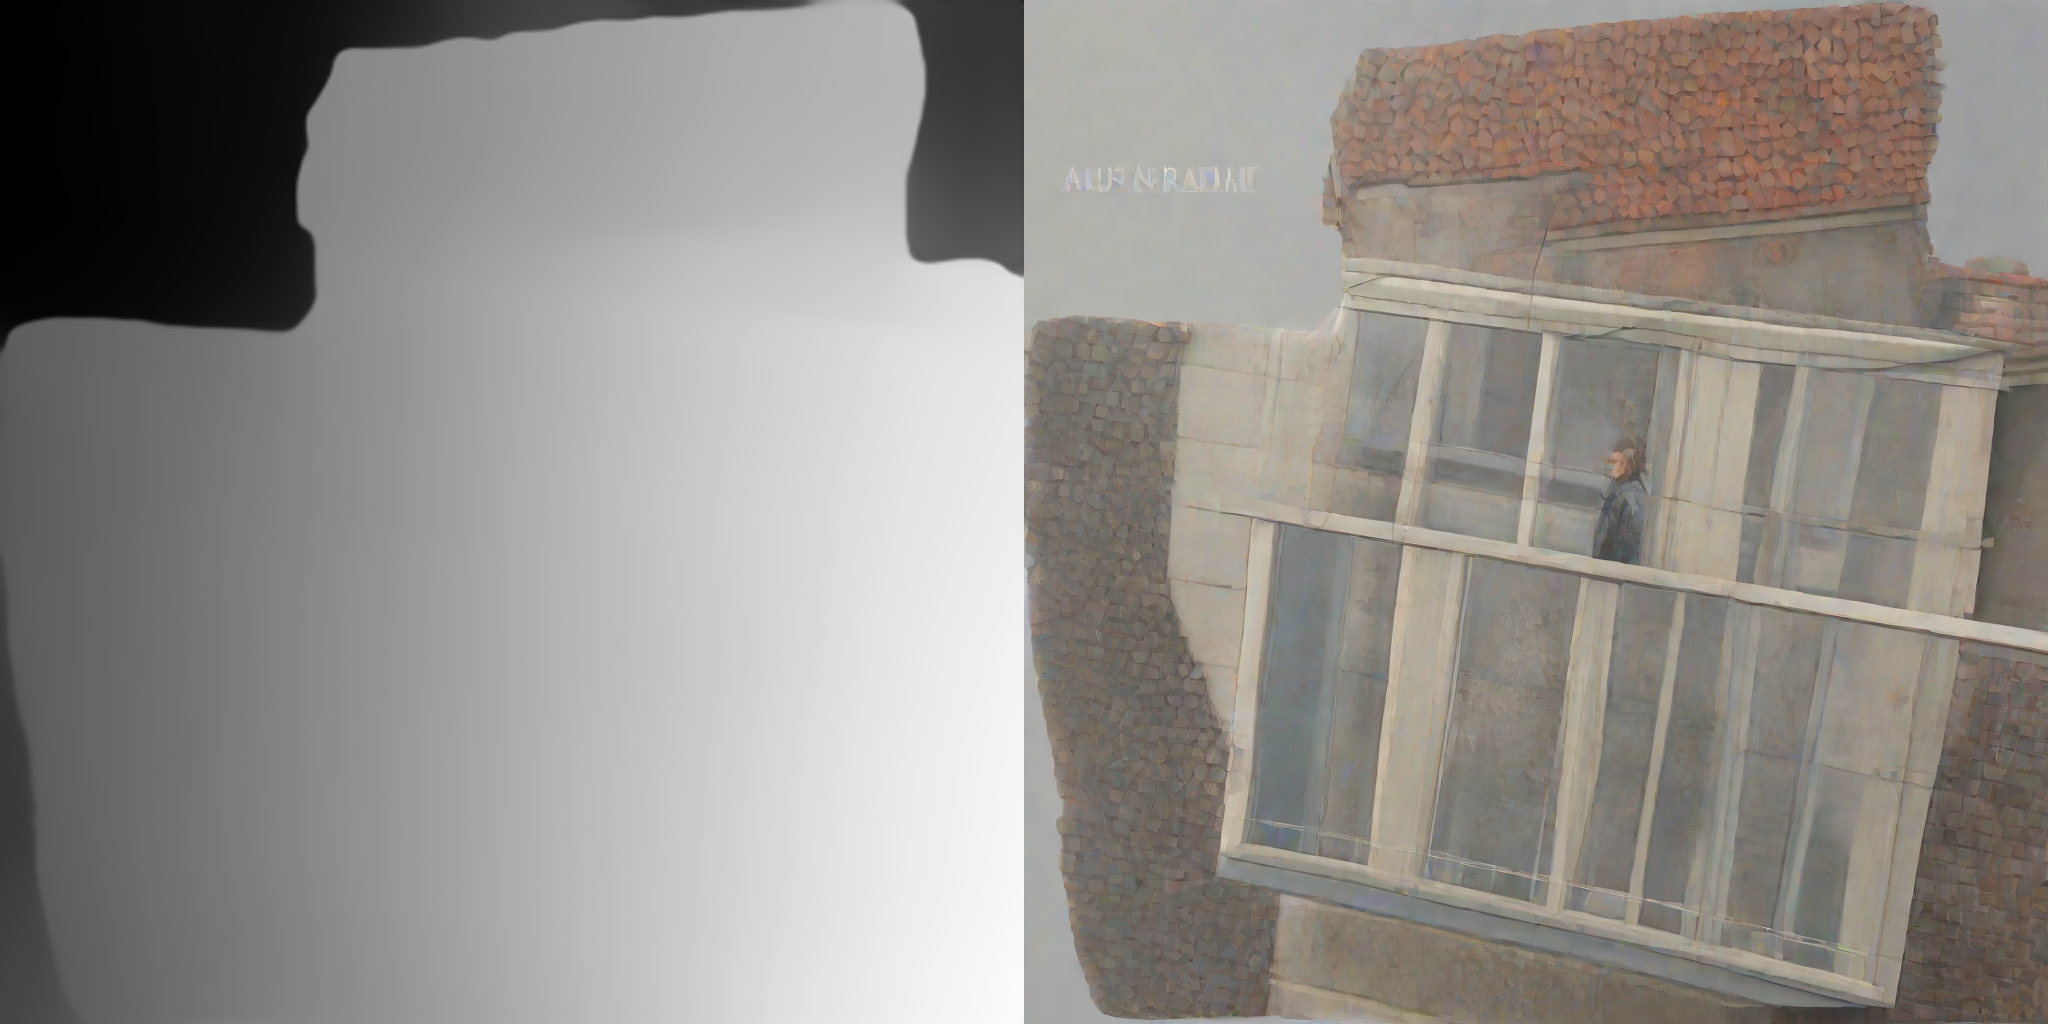

In [118]:
grid_image

In [ ]:
import torch
from diffusers import ControlNetModel, StableDiffusionXLControlNetPipeline
from diffusers.utils import load_image, make_image_grid
import sys
sys.path.insert(0, '/media/kai/K/RMT_LLM/2_Diffusion_tools/stable diffusion/TCD')
from scheduling_tcd import TCDScheduler 

device = "cuda"
base_model_id = "stabilityai/stable-diffusion-xl-base-1.0"
controlnet_id = "diffusers/controlnet-canny-sdxl-1.0"
tcd_lora_id = "h1t/TCD-SDXL-LoRA"

controlnet = ControlNetModel.from_pretrained(
    controlnet_id,
    torch_dtype=torch.float16,
    variant="fp16",
).to(device)
pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
    base_model_id,
    controlnet=controlnet,
    torch_dtype=torch.float16,
    variant="fp16",
).to(device)
pipe.enable_model_cpu_offload()

pipe.scheduler = TCDScheduler.from_config(pipe.scheduler.config)

pipe.load_lora_weights(tcd_lora_id)
pipe.fuse_lora()

prompt = "Pedestrian, rad cloth, Photorealistic,walking,low view: 1.5, solo, isolated, no background, centered."



Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [1]:
import torch
from diffusers import StableDiffusionXLPipeline
import sys
sys.path.insert(0, '/media/kai/K/RMT_LLM/2_Diffusion_tools/stable diffusion/TCD')
from scheduling_tcd import TCDScheduler 
torch.cuda.empty_cache()
device = "cuda"
base_model_id = "stabilityai/stable-diffusion-xl-base-1.0"
tcd_lora_id = "h1t/TCD-SDXL-LoRA"

pipe = StableDiffusionXLPipeline.from_pretrained(base_model_id, torch_dtype=torch.float16, variant="fp16").to(device)
pipe.scheduler = TCDScheduler.from_config(pipe.scheduler.config)

pipe.load_lora_weights(tcd_lora_id)
pipe.fuse_lora()
pipe.enable_model_cpu_offload()
#prompt = "Beautiful woman, bubblegum pink, lemon yellow, minty blue, futuristic, high-detail, epic composition, watercolor."
prompt = "Pedestrian, rad cloth, Photorealistic,walking,low view: 1.5, solo, isolated, no background, centered."


/home/kai/anaconda3/envs/Power/lib/python3.8/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
2024-07-01 14:10:51.541555: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-01 14:10:52.774536: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/kai/anaconda3/envs/Power/lib/python3.8/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/kai/anaconda3/envs/Power/lib/p

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'skip_prk_steps': True} were passed to TCDScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


In [8]:
prompt = "One man, face carama, red clothes, Photorealistic,walking,low view: 1.5, solo, isolated, pure gray background, centered."
image = pipe(
    prompt=prompt,
    num_inference_steps=4,
    guidance_scale=0,
    # Eta (referred to as `gamma` in the paper) is used to control the stochasticity in every step.
    # A value of 0.3 often yields good results.
    # We recommend using a higher eta when increasing the number of inference steps.
    eta=0.3, 
    generator=torch.Generator(device=device).manual_seed(0),
).images[0]

  0%|          | 0/4 [00:00<?, ?it/s]

In [10]:
image.save('temp.png')

In [ ]:
# 将图像转换为灰度图
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 应用 Canny 边缘检测
# 可以调整第二个和第三个参数来控制边缘检测的敏感度
edges = cv2.Canny(gray_image, threshold1=100, threshold2=200)

# 反转颜色，使得边缘是黑色，背景是白色
dst = 255 - edges


# 显示图像
plt.imshow(dst, cmap='gray')
#plt.title('Canny Edge Detected')
plt.axis('off')
cv2.imwrite('figs//30.jpg', dst)

In [64]:
canny_image = load_image("https://huggingface.co/datasets/hf-internal-testing/diffusers-images/resolve/main/sd_controlnet/bird_canny.png")

controlnet_conditioning_scale = 0.5  # recommended for good generalization

In [75]:
object_dirs = "/media/kai/K/RMT_LLM/0_Data/Diffusion/Reference/Fine-tuning/images"
object_dirs = diffusion_utils.get_all_image_paths_1(object_dirs, "*.jpg")
image = cv2.imread(object_dirs[0])
# 将图像转换为灰度图
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 应用 Canny 边缘检测
# 可以调整第二个和第三个参数来控制边缘检测的敏感度
canny_image = cv2.Canny(gray_image, threshold1=100, threshold2=200)

# 反转颜色，使得边缘是黑色，背景是白色
#canny_image = 255 - canny_image


# 显示图像
plt.imshow(dst, cmap='gray')
#plt.title('Canny Edge Detected')
plt.axis('off')
cv2.imwrite('30.jpg', canny_image)

True

In [76]:
canny_image = load_image('30.jpg')

In [77]:
canny_image.shape

AttributeError: 'Image' object has no attribute 'shape'

In [78]:
prompt = "Pedestrian, Photorealistic,walking,low view: 1.5, solo, isolated, no background, centered."
image = pipe(
    prompt, 
    image=canny_image, 
    num_inference_steps=4, 
    guidance_scale=0,
    eta=0.3, # A parameter (referred to as `gamma` in the paper) is used to control the stochasticity in every step. A value of 0.3 often yields good results.
    controlnet_conditioning_scale=controlnet_conditioning_scale,
    generator=torch.Generator(device=device).manual_seed(0),
).images[0]

grid_image = make_image_grid([canny_image, image], rows=1, cols=2)

  0%|          | 0/4 [00:00<?, ?it/s]

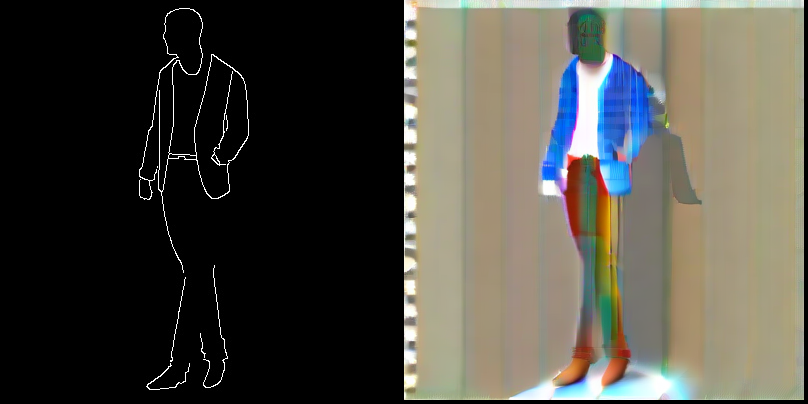

In [79]:
grid_image

In [4]:
from diffusers import ControlNetModel, StableDiffusionXLControlNetPipeline, AutoencoderKL
from diffusers import DDIMScheduler, EulerAncestralDiscreteScheduler
from controlnet_aux import OpenposeDetector
from PIL import Image
import torch
import numpy as np
import cv2



controlnet_conditioning_scale = 1.0  
prompt = "your prompt, the longer the better, you can describe it as detail as possible"
negative_prompt = 'longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality'



eulera_scheduler = EulerAncestralDiscreteScheduler.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", subfolder="scheduler")


controlnet = ControlNetModel.from_pretrained(
    "xinsir/controlnet-openpose-sdxl-1.0",
    torch_dtype=torch.float16
)

# when test with other base model, you need to change the vae also.
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)


pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    controlnet=controlnet,
    vae=vae,
    safety_checker=None,
    torch_dtype=torch.float16,
    scheduler=eulera_scheduler,
)

processor = OpenposeDetector.from_pretrained('lllyasviel/ControlNet')



#images[0].save(f"your image save path, png format is usually better than jpg or webp in terms of image quality but got much bigger")

Keyword arguments {'safety_checker': None} are not expected by StableDiffusionXLControlNetPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
object_dirs = "/media/kai/K/RMT_LLM/0_Data/Diffusion/Reference/Fine-tuning/images"
object_dirs = diffusion_utils.get_all_image_paths_1(object_dirs, "*.jpg")

controlnet_img = cv2.imread(object_dirs[0])
controlnet_img = processor(controlnet_img, hand_and_face=False, output_type='cv2')

prompt = "Pedestrian, Photorealistic,walking,low view: 1.5, solo, isolated, no background, centered."
# need to resize the image resolution to 1024 * 1024 or same bucket resolution to get the best performance
height, width, _  = controlnet_img.shape
ratio = np.sqrt(1024. * 1024. / (width * height))
new_width, new_height = int(width * ratio), int(height * ratio)
controlnet_img = cv2.resize(controlnet_img, (new_width, new_height))
controlnet_img = Image.fromarray(controlnet_img)

images = pipe(
    prompt,
    negative_prompt=negative_prompt,
    image=controlnet_img,
    controlnet_conditioning_scale=controlnet_conditioning_scale,
    width=new_width,
    height=new_height,
    num_inference_steps=30,
    ).images

  0%|          | 0/30 [00:00<?, ?it/s]

In [2]:
import torch
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler
from diffusers.utils import export_to_video

pipe = DiffusionPipeline.from_pretrained("cerspense/zeroscope_v2_576w", torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

prompt = "Darth Vader is surfing on waves"
video_frames = pipe(prompt, num_inference_steps=40, height=320, width=576, num_frames=24).frames
video_path = export_to_video(video_frames)

/home/kai/anaconda3/envs/Power/lib/python3.8/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/kai/anaconda3/envs/Power/lib/python3.8/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


RuntimeError: module compiled against API version 0xf but this version of numpy is 0xe

RuntimeError: Failed to import diffusers.pipelines.pipeline_utils because of the following error (look up to see its traceback):
Failed to import diffusers.models.autoencoders.autoencoder_kl because of the following error (look up to see its traceback):
Failed to import diffusers.loaders.single_file_model because of the following error (look up to see its traceback):
Failed to import transformers.models.auto.image_processing_auto because of the following error (look up to see its traceback):
initialization failed